# Load data

In [55]:
import pandas as pd

insertions_example_df = pd.read_csv("../data/elaborations/insertions_example.csv")
insertions_background_df = pd.read_csv("../data/elaborations/insertions_background.csv")
insertions_generic_df = pd.read_csv("../data/elaborations/insertions_generic.csv")

In [45]:
insertions_generic_df.head()

,text_id,split,insertion,const_tree
0,2,train,forearm,(ROOT (NP (NN forearm)))
1,2,train,kind of,(ROOT (NP (NN kind) (IN of)))
2,2,train,which has,(ROOT (SBAR (WHNP (WDT which)) (S (VP (VBZ has...
3,2,train,These sleeves cover,(ROOT (S (NP (DT These) (NNS sleeves)) (VP (VB...
4,2,train,fabric,(ROOT (NP (NN fabric)))


# Utils

## Constituency trees

In [2]:
import re 

def preprocess(constituency_tree):
    """
    Extract the inner part of the constituency tree, removing the (ROOT ...) wrapper.
    
    :param tree: The full constituency tree as a string.
    :return: The inner part of the constituency tree without (ROOT ...).
    """

    inner_tree = constituency_tree[6:-1]  # Remove the (ROOT and the closing parenthesis)
    stripped_tree = re.sub(r'\([A-Z]+\s[^()]+\)', lambda m: f"({m.group(0).split()[0]})", inner_tree)
    stripped_tree = re.sub(r'\([.,;:!?]+\s[^()]+\)', lambda m: f"({m.group(0).split()[0]})", stripped_tree)

    return stripped_tree

In [28]:
rec = insertions_background_df.iloc[0]
print(rec["const_tree"])
print(preprocess(rec["const_tree"]))

(ROOT (FRAG (CC and) (NP (NN politician)) (. .)))
(FRAG ((CC) (NP ((NN)) ((.))


## Find optimal number of clusters

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def determine_optimal_clusters(X, max_clusters=10):
    """
    Determines the optimal number of clusters using the Elbow Method and Silhouette Score.
    Highlights the top 3 candidates for the best number of clusters.
    
    :param X: The vectorized matrix (features) of the constituency trees.
    :param max_clusters: The maximum number of clusters to test.
    """
    sse = []  
    silhouette_scores = []  

    cluster_range = range(2, max_clusters+1)  # start with 2 clusters, up to max_clusters

    for n_clusters in cluster_range:
        # KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
         
        sse.append(kmeans.inertia_)  # KMeans inertia is the SSE
        
        # Silhouette Score
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)

    # get the top 3 candidates based on Silhouette Score
    top_3_silhouette_idx = np.argsort(silhouette_scores)[-3:]  # indices of top 3 silhouette scores
    # calculate the changes (differences) between successive SSE values
    sse_diffs = np.diff(sse)
    # get the top 3 candidates where the largest drops in SSE (elbow points) occur
    top_3_elbow_idx = np.argsort(-sse_diffs)[:3]
   
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, sse, marker='o', color='blue')
    
    # highlight the top 3 elbow candidates
    for idx in top_3_elbow_idx:
        plt.scatter(cluster_range[idx], sse[idx], color='red', s=100, label=f'Cluster {cluster_range[idx]}')

    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE (Inertia)')
    plt.title('Inertia vs Number of Clusters')
    plt.xticks(cluster_range)
    plt.show()

    # plot the Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
    
    # highlight the top 3 candidates
    for idx in top_3_silhouette_idx:
        plt.scatter(cluster_range[idx], silhouette_scores[idx], color='red', s=100, label=f'Cluster {cluster_range[idx+2]}: {silhouette_scores[idx]:.3f}')

    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xticks(cluster_range)
    plt.legend()
    plt.show()


In [83]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from tqdm.notebook import tqdm

def determine_optimal_clusters_with_distance_matrix(distance_matrix, max_clusters=10):
    """
    Determines the optimal number of clusters using the Elbow Method (with Agglomerative Clustering) 
    and Silhouette Score. Highlights the top 3 candidates for the best number of clusters.
    
    :param distance_matrix: The precomputed distance matrix (pairwise tree edit distances).
    :param max_clusters: The maximum number of clusters to test.
    """
    silhouette_scores = []  
    cluster_range = range(2, max_clusters + 1)  

    for n_clusters in tqdm(cluster_range):
        # Agglomerative Clustering with precomputed distance matrix
        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
        labels = clustering_model.fit_predict(distance_matrix)

        # Calculate Silhouette Score (Silhouette needs the actual pairwise distance matrix)
        silhouette_avg = silhouette_score(distance_matrix, labels, metric='precomputed')
        silhouette_scores.append(silhouette_avg)

    # Get the top 3 candidates based on Silhouette Score
    top_3_silhouette_idx = np.argsort(silhouette_scores)[-3:]

    # Plot the Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o', color='green')

    # Highlight the top 3 candidates
    for idx in top_3_silhouette_idx:
        plt.scatter(cluster_range[idx], silhouette_scores[idx], color='red', s=100, 
                    label=f'Cluster {cluster_range[idx]}: {silhouette_scores[idx]:.3f}')
    
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xticks(cluster_range)
    plt.legend()
    plt.show()

## Get random sample from given cluster

In [38]:
import random

def get_random_samples_per_cluster(df, num_samples=3):
    """
    Randomly selects a given number of samples from each cluster and displays the insertion texts and their constituency trees.
    
    :param df: The clustered DataFrame containing the 'cluster', 'insertion', and 'const_tree' columns.
    :param num_samples: The number of random samples to select per cluster.
    :return: A dictionary containing the random samples from each cluster.
    """
    clusters = sorted(df['cluster'].unique())  # unique cluster labels
    random_samples = {}

    for cluster in clusters:
        # get only samples from the current cluster
        cluster_samples = df[df['cluster'] == cluster]
        
        # select num_samples rows from the current cluster
        selected_samples = cluster_samples.sample(n=num_samples, random_state=42)
        
        # selected samples' insertion texts and their constituency trees
        random_samples[cluster] = {
            'insertion': selected_samples['insertion'].tolist(),
            'const_tree': selected_samples['const_tree'].tolist()
        }
        
        print(f"Cluster {cluster}:\n")
        for i, (insertion_text, const_tree) in enumerate(zip(random_samples[cluster]['insertion'], random_samples[cluster]['const_tree']), 1):
            print(f"{i}) {insertion_text}")
        print(end="\n\n")

## Calculate Tree distance

In [67]:
import re

def parse_string_to_structure(tree_str):
    """
    Converts a constituency tree string into a nested list structure,
    retaining only the syntactic structure and removing the actual words inside.
    
    :param tree_str: A constituency parse tree string (e.g., "(ROOT (S ...))").
    :return: A nested list representing the syntactic structure without words.
    """
    
    def tokenize(tree_str):
        tokens = re.findall(r'\(|\)|[^\s()]+', tree_str)
        return tokens

    # build the structure from tokens
    def build_structure(tokens):
        if not tokens:
            return None

        token = tokens.pop(0)

        if token == '(':
            subtree = []
            while tokens[0] != ')':
                subtree.append(build_structure(tokens))
            tokens.pop(0)  # discard the closing parenthesis ')'
            return subtree
        elif token == ')':
            return None
        else:
            # Only retain the syntactic labels (POS tags and constituency tags) and ignore actual words
            if re.match(r'[A-Z]+', token):  # Only include tags (e.g., NP, VP, etc.)
                return token
            else:
                return ''  # Ignore words

    tokens = tokenize(tree_str)
    nested_structure = build_structure(tokens)

    # Clean up any empty strings from ignored words
    def clean_empty_nodes(tree):
        if isinstance(tree, list):
            return [clean_empty_nodes(subtree) for subtree in tree if subtree]
        return tree

    return clean_empty_nodes(nested_structure)

In [74]:
import zss
from zss import Node
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def parse_tree_to_zss(tree_str):
    """
    Converts a constituency parse tree string into a zss.Node structure for edit distance calculation.
    """
    def tree_builder(tree_list):
        if not tree_list or len(tree_list) == 0:
            return None
        
        root_label = tree_list[0]
        if isinstance(root_label, str):  # Ensure it's a valid string label
            # Recursively build the children
            children = [tree_builder(child) for child in tree_list[1:] if child]
            return Node(root_label, children)
        else:
            return None

    parsed_tree = parse_string_to_structure(tree_str) 
    return tree_builder(parsed_tree)

In [76]:
tree_str = "(ROOT (FRAG (PP (IN since) (NP (CD 2022))) (. .)))"
print(parse_string_to_structure(tree_str))
zss_tree = parse_tree_to_zss(tree_str)
print(zss_tree)

['ROOT', ['FRAG', ['PP', ['IN'], ['NP', ['CD']]], []]]
1:ROOT
1:FRAG
2:PP
0:IN
1:NP
0:CD


In [86]:
from tqdm.notebook import tqdm

def tree_edit_distance(tree1_str, tree2_str):
    """
    Computes the Tree Edit Distance (TED) between two constituency trees.
    """
    tree1 = parse_tree_to_zss(tree1_str)
    tree2 = parse_tree_to_zss(tree2_str)
    return zss.simple_distance(tree1, tree2)

def create_distance_matrix(tree_strings):
    n = len(tree_strings)
    distance_matrix = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            distance = tree_edit_distance(tree_strings[i], tree_strings[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    return distance_matrix

# clustering based on the distance matrix
def perform_clustering(distance_matrix, num_clusters):
    clustering_model = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage='average')
    labels = clustering_model.fit_predict(distance_matrix)
    return labels

# Categorize insertions

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_constituency_trees(df):
    """
    Vectorizes the constituency trees in the DataFrame using a bag-of-words approach.
    
    :param df: The DataFrame containing stripped constituency trees.
    :return: The vectorized matrix of constituency trees.
    """
    vectorizer = CountVectorizer()
    const_trees = df["const_tree"].map(preprocess)
    X = vectorizer.fit_transform(const_trees)  
    
    return X, vectorizer

In [8]:
from sklearn.cluster import KMeans

def perform_clustering(df, num_clusters=5):
    """
    Performs KMeans clustering on the stripped constituency trees (without words).

    :param df: The DataFrame containing stripped constituency trees.
    :param num_clusters: The number of clusters to form.
    :return: The DataFrame with cluster labels added.
    """
    # vectorize the stripped constituency trees
    X, vectorizer = vectorize_constituency_trees(df)

    # KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    return df, kmeans, vectorizer

In [26]:
def analyze_clusters(df, num_clusters):
    """
    Analyzes the clusters by printing the most common constituency patterns in each cluster.

    :param df: The clustered DataFrame.
    :param num_clusters: The number of clusters.
    """
    df['const_tree'] = df['const_tree'].map(preprocess)
    for cluster_num in range(num_clusters):
        print(f"\nCluster {cluster_num} Patterns:")
        
        print(df[df['cluster'] == cluster_num]['const_tree'].value_counts().head())

In [10]:
import matplotlib.pyplot as plt

def plot_cluster_distribution(clustered_df):
    """
    Plots a bar graph of the distribution of samples in each cluster.
    
    :param clustered_df: The DataFrame containing the 'cluster' column.
    """
    # number of samples in each cluster
    cluster_counts = clustered_df["cluster"].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    cluster_counts.plot(kind='bar', color='blue')
    plt.xlabel("Cluster")
    plt.ylabel("Number of Samples")
    plt.title("Cluster Distribution")
    plt.xticks(rotation=0)  
    plt.show()

In [90]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def create_dendrogram(distance_matrix, labels=None):
    """
    Creates a dendrogram from a precomputed distance matrix.
    
    :param distance_matrix: A precomputed distance matrix (symmetric).
    :param labels: Optional labels for the data points (in this case, insertions).
    """
    # Convert the distance matrix into a condensed format (required by scipy's linkage)
    condensed_distance_matrix = squareform(distance_matrix)

    # Perform hierarchical/agglomerative clustering to get the linkage matrix
    linkage_matrix = linkage(condensed_distance_matrix, method='average')
    
    # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, labels=labels, leaf_rotation=90, leaf_font_size=10)
    
    plt.title('Dendrogram for Insertions')
    plt.xlabel('Insertions')
    plt.ylabel('Distance')
    plt.show()

## Find best num of clusters

In [80]:
insertion_df = insertions_example_df
insertion_df.dropna(inplace=True)
insertion_df.drop_duplicates(inplace=True)

## K-means

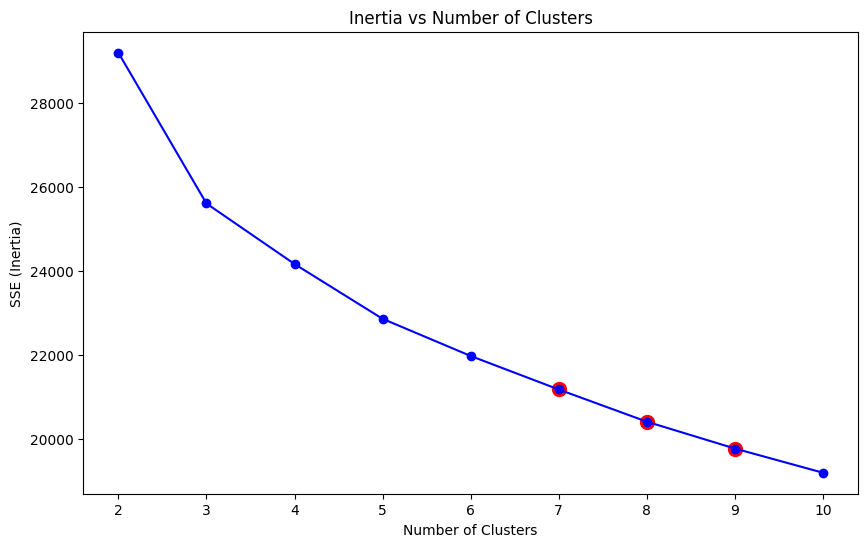

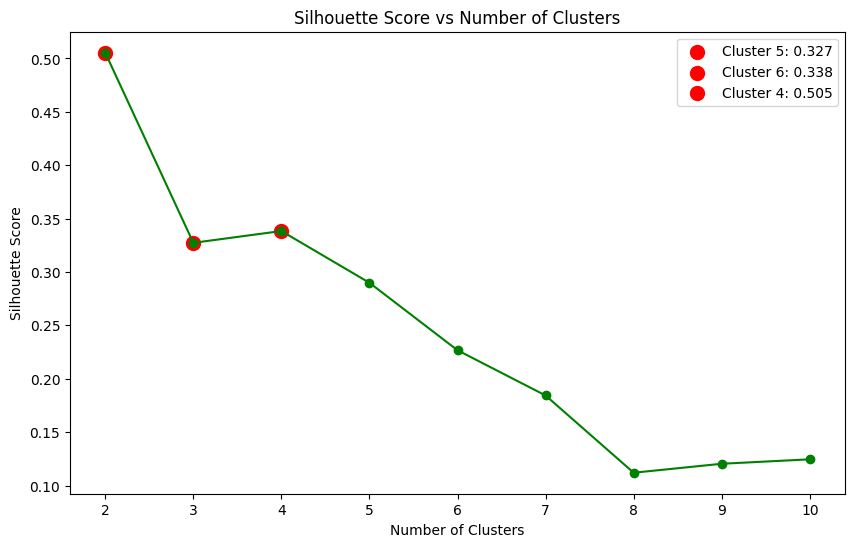

In [48]:
X, vectorizer = vectorize_constituency_trees(insertion_df)
determine_optimal_clusters(X, max_clusters=10)

## Agglomerative clustering

  0%|          | 0/9 [00:00<?, ?it/s]

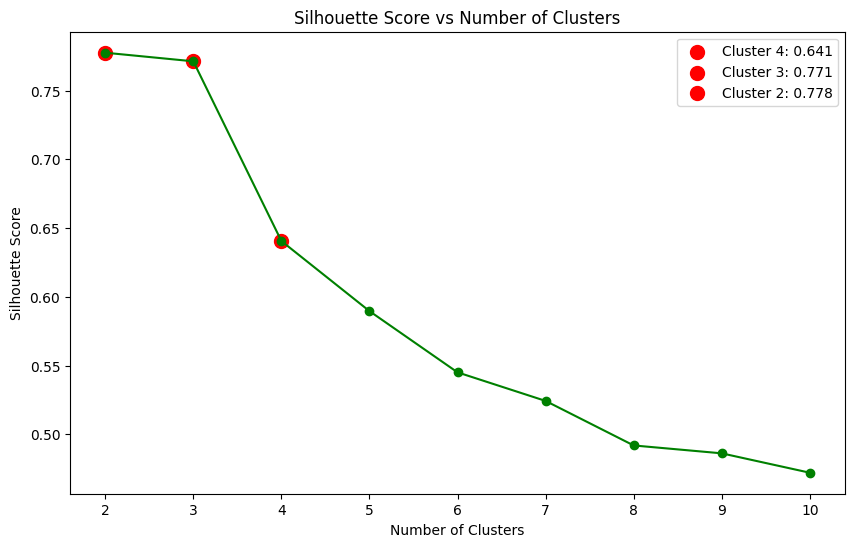

In [84]:
tree_strs = insertion_df['const_tree'].tolist() 
distance_matrix = create_distance_matrix(tree_strs)

determine_optimal_clusters_with_distance_matrix(distance_matrix, max_clusters=10)

## K-means Clustering

In [49]:
clustered_df, kmeans_model, vectorizer = perform_clustering(insertion_df, num_clusters=4)

## Agglomerative clustering

In [87]:
tree_strs = insertion_df['const_tree'].tolist()  
distance_matrix = create_distance_matrix(tree_strs)
labels = perform_clustering(distance_matrix, num_clusters=3)
insertion_df['cluster'] = labels
clustered_df = insertion_df

  0%|          | 0/196 [00:00<?, ?it/s]

In [88]:
clustered_df.head()

,text_id,split,insertion,const_tree,cluster
0,21,train,since 2022.,(ROOT (FRAG (PP (IN since) (NP (CD 2022))) (. ...,0
1,24,train,(Give up being the King or Queen),(ROOT (S (-LRB- -LRB-) (S (VP (VB Give) (PRT (...,0
2,25,train,if,(ROOT (IN if)),0
3,25,train,song has 4 beats per bar at 100 BPM,(ROOT (S (NP (NN song)) (VP (VBZ has) (NP (NP ...,0
4,25,train,25 bars,(ROOT (NP (CD 25) (NNS bars))),0


# Semantic elaboration example

## K-means

In [5]:
import pandas as pd
example_df = pd.read_csv("../data/elaborations/example.csv")

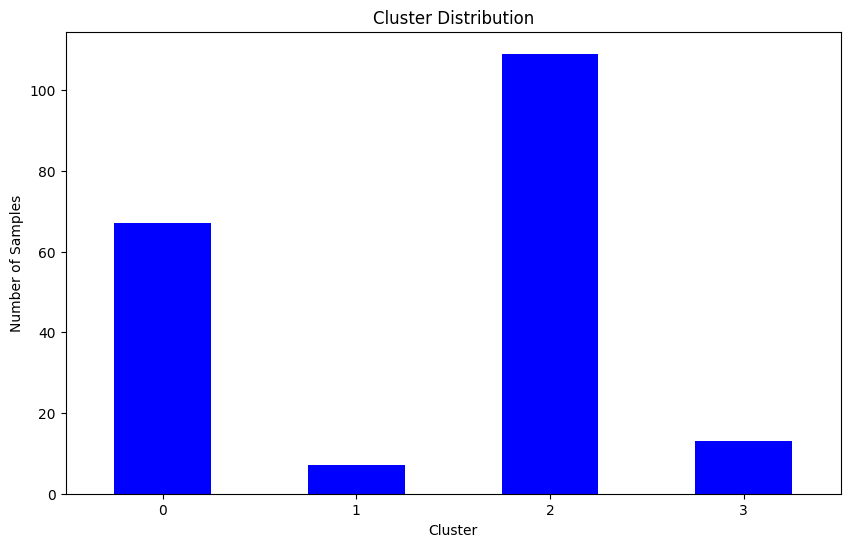

In [14]:
plot_cluster_distribution(clustered_df)

In [19]:
get_random_samples_per_cluster(clustered_df, num_samples=5)

Cluster 2:

1) writes about
2) is usually seen in Churches and Cathedrals
3) there will
4) plants
5) the other


Cluster 3:

1) machine for making a point at the end of a
2)  The name TaeTiSeo is a portmanteau of the girls' names
3) song has 4 beats per bar at 100 BPM
4) common arithmetic to show that the numerator is being divided by the denominator as a whole group.
5) skirts, or for carrying things using intergrated pockets as a utility belt


Cluster 0:

1) and Sonic the Hedgehog
2)  For example, Catalan is only official
3) At this point enzyme velocity linearly increases.
4) Scientists have seen it between 680
5) very small objects you need


Cluster 1:

1) results and gives people links to websites that are most likely what they want
2)  So, if the original stimulus was an invading bacterium, these channels disrupt the phospholipid bilayer cell membrane
3)  Examples are: oxygen, fresh water, solar energy, timber, and biomass.
4)  When this is done, the player's team who had caugh

In [23]:
clustered_df

,text_id,split,insertion,const_tree,cluster
0,21,train,since 2022.,(ROOT (FRAG (PP (IN since) (NP (CD 2022))) (. ...,2
1,24,train,(Give up being the King or Queen),(ROOT (S (-LRB- -LRB-) (S (VP (VB Give) (PRT (...,2
2,25,train,if,(ROOT (IN if)),2
3,25,train,song has 4 beats per bar at 100 BPM,(ROOT (S (NP (NN song)) (VP (VBZ has) (NP (NP ...,3
4,25,train,25 bars,(ROOT (NP (CD 25) (NNS bars))),2
...,...,...,...,...,...
267,306,test_ood,"election(or a vote), and",(ROOT (NP (NP (NN election)) (-LRB- -LRB-) (CC...,0
268,306,test_ood,Each voter will then rank the options accordi...,(ROOT (S (NP (DT Each) (NN voter)) (VP (MD wil...,0
271,352,test_ood,like a candy bar or it can be in,(ROOT (PP (IN like) (S (NP (NP (DT a) (NN cand...,0
272,352,test_ood,form like hot chocolate,(ROOT (NP (NP (NN form)) (PP (IN like) (NP (JJ...,0


In [27]:
analyze_clusters(clustered_df, num_clusters=4)


Cluster 0 Patterns:
const_tree
(NP (NP (NP ((DT) ((NN)) (PP ((IN) (NP ((CD) ((NNS)))) (PP ((IN) (NP ((CD))) ((.))                                                                                                                          1
(SINV (VP ((VBZ)) (NP (NP ((DT) ((JJ) ((NN)) (PP ((IN) (NP ((DT) (NML ((NNP) ((NNPS)) ((NNP)))))                                                                                                            1
(S ((CC) (NP (NP ((NNP)) (NP ((DT) ((NNP))))                                                                                                                                                                1
(S ((,) (S (NP (NP ((NN)) (SBAR (S (NP ((PRP)) (ADVP ((RB)) (VP ((VBD) (S (VP ((TO) (VP ((VB) (PP ((IN) (NP ((NN) ((.)))))))))) ((CC) (VP ((VBD) (ADJP ((JJ) (S (VP ((TO) (VP ((VB))))))) (-RRB- -RRB-))    1
(NP (NP (QP ((DT) ((CD) ((CD) ((CD))) (-LRB- -LRB-) (NP ((CD)))                                                                                 

# Semantic elaboration background

In [35]:
import pandas as pd
background_df = pd.read_csv("../data/elaborations/background.csv")

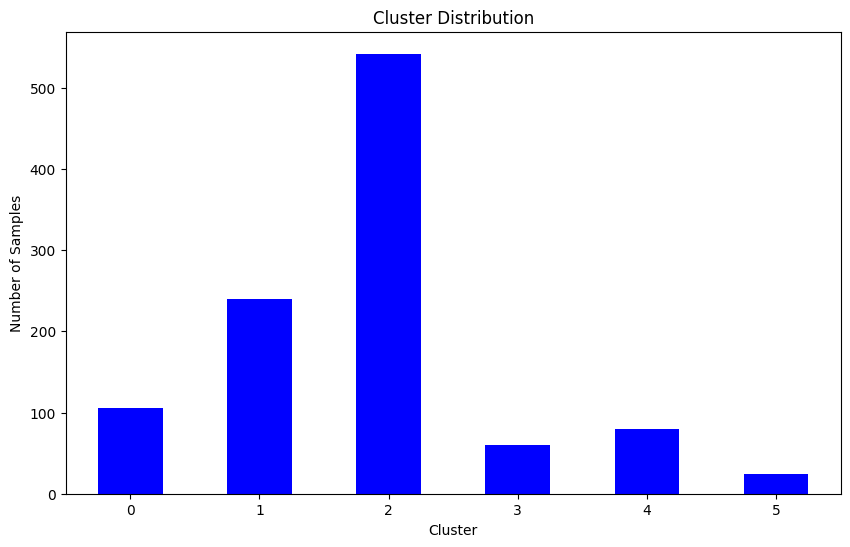

In [36]:
plot_cluster_distribution(clustered_df)

In [39]:
get_random_samples_per_cluster(clustered_df, num_samples=5)

Cluster 0:

1) The clubs plays at the Tofiq Bahramov Republican Stadium,
2)  It is different from Inner Mongolia, which is
3) Saare Jahan se Achcha is a poem.
4)  Costas died on 15 December 2020, aged 78.
5) de Margerie was born in Mareuil-sur-Lay, France.


Cluster 1:

1)  The third was the
2) disease two months later on May 27
3)  It refers to the a
4) are B cells(or" B
5) who wants to join a gang


Cluster 2:

1) Florida
2) southwestern
3) The Province of
4) Easy listening
5) until his death.


Cluster 3:

1)  On 3 January 2020, Brezinka died in Telfes, in the Austrian state of Tyrol.
2) discoered in its valley: The Acheulean is named after [[Saint-Acheul], a suburb of Amiens
3) , at the age of 67 from sepsis caused by COVID-19
4) Despite the departure of Arch, Fates Warning's popularity continued with their
5) He was born in Tuzla, Kingdom of Yugoslavia(modern-day Bosnia).


Cluster 4:

1) Some sources mention 1947 as her birth date, while others say 1948
2) died from pneumonia cau

# Semantic elaboration generic

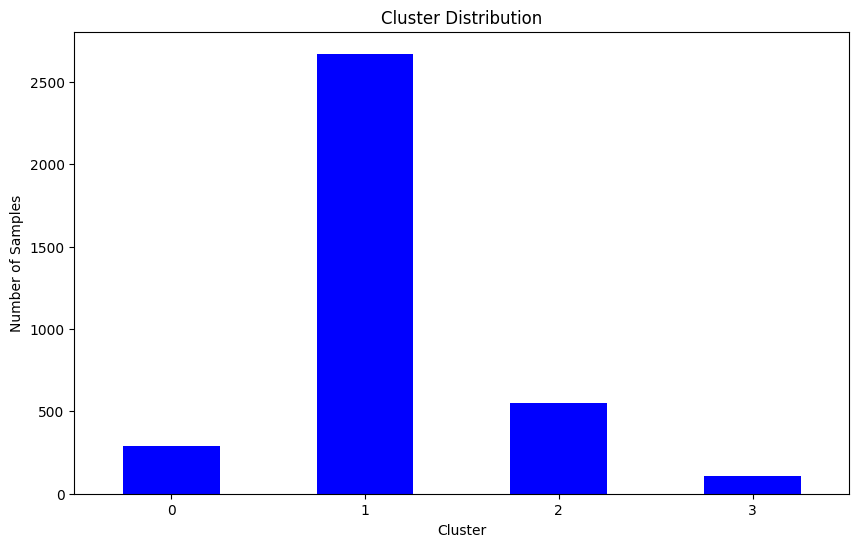

In [50]:
plot_cluster_distribution(clustered_df)

In [51]:
get_random_samples_per_cluster(clustered_df, num_samples=5)

Cluster 0:

1) Linux itself) and application
2) (British American Scientific International Commercial)
3) 1979 near Camden
4) (Arabic: سفيان الشعري; born July
5) and authenticated(via rsh or SFTP)


Cluster 1:

1) a county
2) concentration camp
3)  His team at
4) 17th and current
5) - 18 July 2020


Cluster 2:

1) dairy food used in many
2) from 2008 through 2013
3) able to bowl both fast and as a spinner, Sobers is
4) that is played every holiday season.
5) musician, best known as the co-founder and


Cluster 3:

1) behaves in an immoral way: a man who has relationships with lots of women.
2) He finished his law studies at the University of Ghent in 1885.
3) She hosted Wowowee, at the same time she appeared as Veronica in the afternoon TV series Rosalka.
4) ordered the freedom of all slaves residing in those states still in rebellion
5)  Photos of the person's head are scanned into the system to prevent identity theft.


